In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rain/weatherAUS.csv')

In [31]:
df

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

##  Удаляю лишние столбцы и строки "учителя" с NaN


In [33]:
df.drop(['Date', 'Evaporation', 'Sunshine','Cloud9am','Cloud3pm'], axis=1, inplace=True)

In [34]:
df = df.dropna(subset=['RainTomorrow'])

In [35]:
df

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,Uluru,3.5,21.8,0.0,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,No,No
145455,Uluru,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,No
145456,Uluru,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,No
145457,Uluru,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,No


## Заполняю числовые столбцы с NaN

### Числовые строки убираю

In [36]:
nans = df.loc[:, df.isnull().any()]
nans

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday
0,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No
1,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No
2,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No
3,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No
4,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,3.5,21.8,0.0,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,No
145455,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No
145456,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No
145457,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No


In [37]:
col_with_nans_num = df.select_dtypes(include=['float64'])
list(col_with_nans_num.columns)

['MinTemp',
 'MaxTemp',
 'Rainfall',
 'WindGustSpeed',
 'WindSpeed9am',
 'WindSpeed3pm',
 'Humidity9am',
 'Humidity3pm',
 'Pressure9am',
 'Pressure3pm',
 'Temp9am',
 'Temp3pm']

In [38]:
def remove_nan_num(df_with_nan):
    for col_key, col_val in df_with_nan.items():
        df_with_nan[col_key].fillna(df[col_key].mean(), inplace=True)
    return df_with_nan

In [ ]:
df[list(col_with_nans_num.columns)] = remove_nan_num(df[list(col_with_nans_num.columns)])

### Замена Yes-No

In [ ]:
df['RainToday'].replace({'Yes': 1, 'No' : 0}, inplace=True)
df['RainTomorrow'].replace({'Yes': 1, 'No' : 0}, inplace=True)

In [ ]:
df['RainToday'].fillna(df['RainToday'].mean(), inplace=True)

### Делаю OneHotCoding

In [42]:
list_colums_with_str = df.columns.to_series().groupby(df.dtypes).groups
list_colums_with_str = {k.name: v for k, v in list_colums_with_str.items()}
list_colums_with_str

{'float64': Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
        'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
        'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday'],
       dtype='object'),
 'int64': Index(['RainTomorrow'], dtype='object'),
 'object': Index(['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')}

In [43]:
df_ext = pd.concat(
    [df.drop(list_colums_with_str['object'], axis=1),
     pd.get_dummies(df[list_colums_with_str['object']], prefix=list_colums_with_str['object'])],
    axis=1)

In [ ]:
df_ext

In [45]:
df_ext.to_csv('/content/drive/MyDrive/Colab Notebooks/rain/clear_data_rain.csv', index=False)

## Разбиваю данные train и valid

In [46]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/rain/clear_data_rain.csv')

In [ ]:
nans = df.loc[:, df.isnull().any()]
nans

In [48]:
# конвертируем в numpy

x, y = df.drop(['RainTomorrow'], axis=1).to_numpy(), df['RainTomorrow'].to_numpy()
x.shape, y.shape


((142193, 110), (142193,))

In [49]:
# разбиваем на трейн/тест выборки

from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, random_state=1)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((99535, 110), (42658, 110), (99535,), (42658,))

In [50]:
# # нормируем данные

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_valid_norm = scaler.transform(x_valid)
x_train_norm

# from sklearn.preprocessing import RobustScaler
# rb = RobustScaler()
# rb.fit(x_train)
# x_train_norm = rb.transform(x_train)
# x_valid_norm = rb.transform(x_valid)

array([[-0.27922234, -1.07323685,  0.24291763, ..., -0.27476528,
        -0.25356465, -0.26421333],
       [ 0.04921564, -0.91846567, -0.278755  , ..., -0.27476528,
        -0.25356465, -0.26421333],
       [-0.87353869,  0.08051193, -0.278755  , ..., -0.27476528,
         3.94376738, -0.26421333],
       ...,
       [-2.01525167, -1.88930305, -0.16019304, ..., -0.27476528,
        -0.25356465, -0.26421333],
       [-0.9204584 , -0.39787171, -0.278755  , ..., -0.27476528,
        -0.25356465, -0.26421333],
       [-0.26358244, -1.1717276 , -0.08905586, ..., -0.27476528,
        -0.25356465, -0.26421333]])

# Tenserflow

In [94]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [95]:
input_shape = x_train_norm.shape[1]
input_shape

110

In [104]:

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Dense(100, activation='sigmoid'),
        layers.Dropout(.5),
        layers.Dense(100, activation='sigmoid'),
        layers.Dense(50, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               11100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 26,301
Trainable params: 26,301
Non-trainable params: 0
_________________________________________________________________


In [105]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=tf.keras.metrics.AUC(),
    optimizer=keras.optimizers.Adam(lr=0.01, amsgrad=True)
)


In [106]:
tf.keras.backend.clear_session()

In [107]:
history = model.fit(x_train_norm, 
                    y_train, 
                    batch_size=1000, 
                    epochs=20, 
                    validation_data=(x_valid_norm, y_valid), 
                    verbose=1)

Epoch 1/20
100/100 [==============================] - 2s 16ms/step - loss: 0.5028 - auc: 0.6840 - val_loss: 0.3657 - val_auc: 0.8602
Epoch 2/20
100/100 [==============================] - 1s 13ms/step - loss: 0.3686 - auc: 0.8552 - val_loss: 0.3528 - val_auc: 0.8670
Epoch 3/20
100/100 [==============================] - 1s 13ms/step - loss: 0.3589 - auc: 0.8612 - val_loss: 0.3487 - val_auc: 0.8704
Epoch 4/20
100/100 [==============================] - 1s 13ms/step - loss: 0.3518 - auc: 0.8674 - val_loss: 0.3459 - val_auc: 0.8749
Epoch 5/20
100/100 [==============================] - 1s 13ms/step - loss: 0.3497 - auc: 0.8690 - val_loss: 0.3426 - val_auc: 0.8771
Epoch 6/20
100/100 [==============================] - 1s 13ms/step - loss: 0.3441 - auc: 0.8737 - val_loss: 0.3390 - val_auc: 0.8795
Epoch 7/20
100/100 [==============================] - 1s 13ms/step - loss: 0.3405 - auc: 0.8776 - val_loss: 0.3378 - val_auc: 0.8812
Epoch 8/20
100/100 [==============================] - 1s 13ms/step - 

Text(0.5, 1.0, 'Loss')

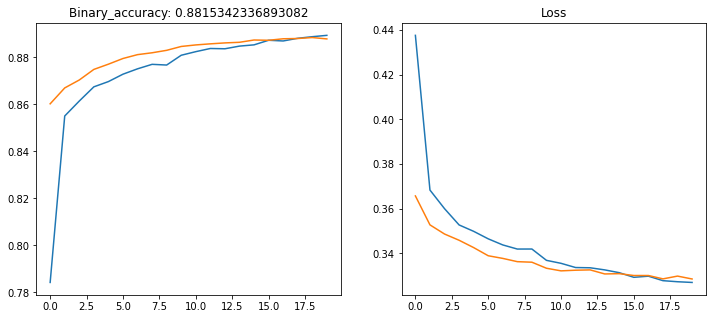

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['auc'])
ax1.plot(history.history['val_auc'])
ax1.set_title(f"Binary_accuracy: {np.mean(history.history['val_auc'])}")

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Loss')